
# Stratified Sampling Walkthrough (`stratification.ipynb`)

This notebook recreates the stratified sampling logic step-by-step with **visible intermediate outputs**:
- Binning probes by 0.1-wide `Log Intensity` intervals
- Sampling evenly across bins
- Enforcing **motif uniqueness** with rotating k-mer columns (`6mer`, `8mer`, `10mer`, `12mer`)
- Reproducible random draws via seeded sampling

**Prerequisite**: You should have already exported `gcPBM_myc_final.csv` from your processing notebook.  
If not, place that file in the same directory as this notebook before running.


In [1]:

import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

# Load the CSV you exported from process_gcPBM.ipynb
CSV_PATH = 'gcPBM_myc_final.csv'  # change if needed
df0 = pd.read_csv(CSV_PATH)
print("Loaded shape:", df0.shape)
display(df0.head())

# Sanity checks for required columns
needed = ['SEQUENCE','Log Intensity','6mer','8mer','10mer','12mer']
missing = [c for c in needed if c not in df0.columns]
print("Missing needed columns:", missing)
if missing:
    print("\nWARNING: Some required columns are missing. Ensure you exported them. "
          "You can still proceed to explore, but sampling may not work as intended.")


Loaded shape: (7160, 9)


,Name,SEQUENCE,Mean Intensity,Probe,Log Intensity,12mer,10mer,8mer,6mer
0,Unbound_Myc1_001,TCCAGCAAACTTTTCTTTGTTCGCTGCAGTGCCGCC,1355,Unbound,7.211557,TTCTTTGTTCGC,TCTTTGTTCG,CTTTGTTC,TTTGTT
1,Unbound_Myc1_002,GGGCTCCCAGGGGCTGCTGCTGCCTTTCCGGTCTTG,1042,Unbound,6.948897,GCTGCTGCTGCC,CTGCTGCTGC,TGCTGCTG,GCTGCT
2,Unbound_Myc1_003,TATGGAGGATAACTTGGTACAGCCCCTATAGAGGGC,1320,Unbound,7.185387,CTTGGTACAGCC,TTGGTACAGC,TGGTACAG,GGTACA
3,Unbound_Myc1_004,GGAATCTGAGGGATGAAGACTCAGGTCAGCAGGCTG,1192,Unbound,7.083388,ATGAAGACTCAG,TGAAGACTCA,GAAGACTC,AAGACT
4,Unbound_Myc1_005,AGCGCACTTCAGGGAACCGCACTTAGGGTCCGATGG,1491,Unbound,7.307202,GGAACCGCACTT,GAACCGCACT,AACCGCAC,ACCGCA


Missing needed columns: []


In [2]:

# Intensity thresholds (tweak to experiment)
LOW_MAX  = 8.0   # <= this -> unbound
MID_MIN  = 8.0   # (MID_MIN, MID_MAX) -> weak
MID_MAX  = 9.0   # >= this -> strong

unbound = df0[df0['Log Intensity'] <= LOW_MAX].copy()
weak    = df0[(df0['Log Intensity'] > MID_MIN) & (df0['Log Intensity'] < MID_MAX)].copy()
strong  = df0[df0['Log Intensity'] >= MID_MAX].copy()

print("Counts by class:")
print("  unbound:", len(unbound))
print("  weak   :", len(weak))
print("  strong :", len(strong))


Counts by class:
  unbound: 1289
  weak   : 3753
  strong : 2118


In [3]:

def bin_and_report(df, label):
    if df.empty:
        print(f"[{label}] Empty set.")
        return df

    low  = round(df['Log Intensity'].min(), 1)
    high = round(df['Log Intensity'].max(), 1)
    bins = np.arange(low, high + 0.1, 0.1)

    print(f"\n[{label}] Log Intensity range: [{low}, {high}] step=0.1")
    print(f"[{label}] Num bins (edges-1): {len(bins)-1}")

    df = df.copy()
    df['bin'] = pd.cut(df['Log Intensity'], bins)
    counts = df['bin'].value_counts().sort_index()
    print(f"[{label}] Rows per bin (first 12 shown):")
    display(counts.to_frame('count').head(12))
    return df

unbound_b = bin_and_report(unbound, "UNBOUND")
weak_b    = bin_and_report(weak,    "WEAK")
strong_b  = bin_and_report(strong,  "STRONG")



[UNBOUND] Log Intensity range: [6.8, 8.0] step=0.1
[UNBOUND] Num bins (edges-1): 12
[UNBOUND] Rows per bin (first 12 shown):


,count
"(6.8, 6.9]",3
"(6.9, 7.0]",15
"(7.0, 7.1]",39
"(7.1, 7.2]",50
"(7.2, 7.3]",67
...,...
"(7.5, 7.6]",97
"(7.6, 7.7]",145
"(7.7, 7.8]",162
"(7.8, 7.9]",238



[WEAK] Log Intensity range: [8.0, 9.0] step=0.1
[WEAK] Num bins (edges-1): 10
[WEAK] Rows per bin (first 12 shown):


,count
"(8.0, 8.1]",353
"(8.1, 8.2]",440
"(8.2, 8.3]",499
"(8.3, 8.4]",529
"(8.4, 8.5]",457
"(8.5, 8.6]",443
"(8.6, 8.7]",344
"(8.7, 8.8]",290
"(8.8, 8.9]",228
"(8.9, 9.0]",170



[STRONG] Log Intensity range: [9.0, 11.3] step=0.1
[STRONG] Num bins (edges-1): 24
[STRONG] Rows per bin (first 12 shown):


,count
"(9.0, 9.1]",130
"(9.1, 9.2]",141
"(9.2, 9.3]",136
"(9.3, 9.4]",140
"(9.4, 9.5]",135
...,...
"(9.7, 9.8]",150
"(9.8, 9.9]",118
"(9.9, 10.0]",141
"(10.0, 10.1]",154


In [4]:

# How many to sample from each class
TARGET_PER_CLASS = 33   # change to experiment

# k-mer uniqueness rotation order
MOTIF_ORDER = ['6mer','8mer','10mer','12mer']

# Reproducibility
SEEDS = list(range(10000))

print("TARGET_PER_CLASS:", TARGET_PER_CLASS)
print("MOTIF_ORDER:", MOTIF_ORDER[:])


TARGET_PER_CLASS: 33
MOTIF_ORDER: ['6mer', '8mer', '10mer', '12mer']


In [5]:

def sample_across_bins_with_uniques(df_binned, target_n, motif_order, seeds, label):
    '''
    df_binned : DataFrame with a 'bin' column (from pd.cut)
    target_n  : number of rows to sample
    motif_order : list of motif column names to rotate through
    seeds     : list of ints for reproducible picks
    label     : string label for printing
    '''
    if df_binned.empty:
        print(f"[{label}] Empty set. Returning empty sample.")
        return df_binned.head(0).copy()

    samples = []
    picked_count = 0
    motif_idx = 0
    motif = motif_order[motif_idx]
    used_motifs = set()

    print(f"\n[{label}] START sampling")
    print(f"[{label}] Target n = {target_n}, starting motif = {motif}")

    # Loop multiple passes until we reach target or run out of motifs
    passes = 0
    while picked_count < target_n:
        passes += 1
        print(f"\n[{label}] === PASS {passes} | motif={motif} ===")

        len_motifs_per_bin = []
        for br in df_binned['bin'].cat.categories:
            group = df_binned[df_binned['bin'] == br]
            if group.empty:
                len_motifs_per_bin.append(0)
                continue

            # Available motifs in this bin (not yet used)
            available = group.loc[~group[motif].isin(used_motifs), motif].unique()
            len_motifs_per_bin.append(len(available))

            if len(available) > 0 and picked_count < target_n:
                sub = group[group[motif].isin(available)]
                seed = seeds[picked_count] if picked_count < len(seeds) else None
                pick = sub.sample(n=1, random_state=seed)

                samples.append(pick)
                picked_motif = pick.iloc[0][motif]
                used_motifs.add(picked_motif)
                picked_count += 1

                print(f"[{label}] Bin {br}: PICKED idx={pick.index.tolist()} motif={picked_motif} "
                      f"(picked={picked_count}/{target_n})")

                if picked_count >= target_n:
                    break

        # If no bin had any available motifs under the current motif, rotate
        if all(l == 0 for l in len_motifs_per_bin):
            motif_idx += 1
            if motif_idx < len(motif_order):
                motif = motif_order[motif_idx]
                used_motifs = set()
                print(f"[{label}] Rotating motif to {motif} (no uniques left at previous length)")
            else:
                print(f"[{label}] Out of motif columns; stopping early (picked={picked_count}).")
                break

    if samples:
        out = pd.concat(samples, ignore_index=True).drop(columns='bin')
    else:
        out = df_binned.head(0).copy()

    print(f"[{label}] DONE: picked {len(out)} rows.")
    return out


In [6]:

unbound_sample = sample_across_bins_with_uniques(unbound_b, TARGET_PER_CLASS, MOTIF_ORDER, SEEDS, "UNBOUND")
weak_sample    = sample_across_bins_with_uniques(weak_b,    TARGET_PER_CLASS, MOTIF_ORDER, SEEDS, "WEAK")
strong_sample  = sample_across_bins_with_uniques(strong_b,  TARGET_PER_CLASS, MOTIF_ORDER, SEEDS, "STRONG")

print("\nSample sizes:")
print("  unbound:", len(unbound_sample))
print("  weak   :", len(weak_sample))
print("  strong :", len(strong_sample))



[UNBOUND] START sampling
[UNBOUND] Target n = 33, starting motif = 6mer

[UNBOUND] === PASS 1 | motif=6mer ===
[UNBOUND] Bin (6.8, 6.9]: PICKED idx=[231] motif=CAAAAT (picked=1/33)
[UNBOUND] Bin (6.9, 7.0]: PICKED idx=[31] motif=AGAGAG (picked=2/33)
[UNBOUND] Bin (7.0, 7.1]: PICKED idx=[121] motif=AATGGC (picked=3/33)
[UNBOUND] Bin (7.1, 7.2]: PICKED idx=[62] motif=ACTTCC (picked=4/33)
[UNBOUND] Bin (7.2, 7.3]: PICKED idx=[67] motif=CCCCTT (picked=5/33)
[UNBOUND] Bin (7.3, 7.4]: PICKED idx=[217] motif=TGGGTT (picked=6/33)
[UNBOUND] Bin (7.4, 7.5]: PICKED idx=[1356] motif=CGCATG (picked=7/33)
[UNBOUND] Bin (7.5, 7.6]: PICKED idx=[893] motif=CACGCG (picked=8/33)
[UNBOUND] Bin (7.6, 7.7]: PICKED idx=[5932] motif=CTCGTG (picked=9/33)
[UNBOUND] Bin (7.7, 7.8]: PICKED idx=[5345] motif=CGCGTG (picked=10/33)
[UNBOUND] Bin (7.8, 7.9]: PICKED idx=[3496] motif=CATGCG (picked=11/33)
[UNBOUND] Bin (7.9, 8.0]: PICKED idx=[3019] motif=CATGTG (picked=12/33)

[UNBOUND] === PASS 2 | motif=6mer ===
[UNB

In [ ]:

final_sample = pd.concat([unbound_sample, weak_sample, strong_sample], ignore_index=True)

print("Final combined shape:", final_sample.shape)
display(final_sample.head())

# Quick sanity checks
print("\nCounts by intensity class (using same thresholds):")
print("unbound (<=8):", (final_sample['Log Intensity'] <= 8).sum())
print("weak   (8-9) :", ((final_sample['Log Intensity'] > 8) & (final_sample['Log Intensity'] < 9)).sum())
print("strong (>=9) :", (final_sample['Log Intensity'] >= 9).sum())

# # Save
# final_sample.to_csv('dataset_old.csv', index=False)
# print("Saved to dataset_old.csv")``


Final combined shape: (99, 9)


,Name,SEQUENCE,Mean Intensity,Probe,Log Intensity,12mer,10mer,8mer,6mer
0,Unbound_Myc2_090,GTACACAATTTTTTACAAAATTTAAATTAAAACAAA,932,Unbound,6.837333,TTACAAAATTTA,TACAAAATTT,ACAAAATT,CAAAAT
1,Unbound_Myc1_033,GCAGCCGAGGCGGAGAGAGAGAGAGGACAGCTTACG,1093,Unbound,6.996681,GAGAGAGAGAGA,AGAGAGAGAG,GAGAGAGA,AGAGAG
2,Unbound_Myc1_128,AGGCCCAGGAAGAACAATGGCTCTGCCAACTGGGCA,1142,Unbound,7.040536,AACAATGGCTCT,ACAATGGCTC,CAATGGCT,AATGGC
3,Unbound_Myc1_065,CTTCCTCACCTGCAGACTTCCTTCCCTGAGTCCCAG,1282,Unbound,7.156177,CAGACTTCCTTC,AGACTTCCTT,GACTTCCT,ACTTCC
4,Unbound_Myc1_070,TGAGGGTCAGAGGCACCCCTTCCTGGAATCTCCTTC,1444,Unbound,7.275172,GCACCCCTTCCT,CACCCCTTCC,ACCCCTTC,CCCCTT



Counts by intensity class (using same thresholds):
unbound (<=8): 33
weak   (8-9) : 33
strong (>=9) : 33
Saved to dataset_old.csv


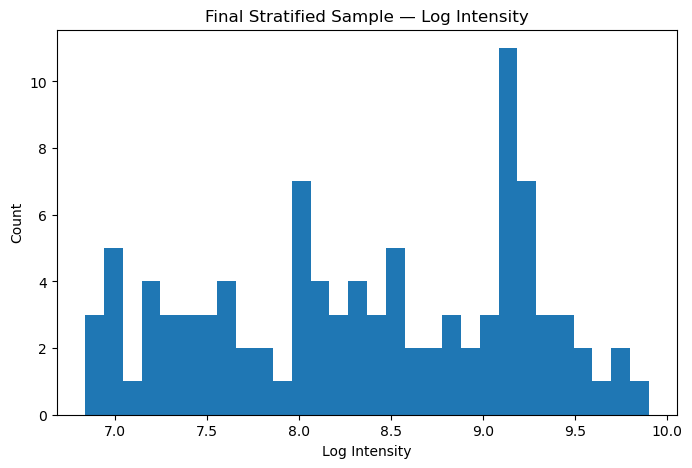

In [8]:

# Optional: quick histogram to visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(final_sample['Log Intensity'], bins=30)
plt.xlabel('Log Intensity')
plt.ylabel('Count')
plt.title('Final Stratified Sample — Log Intensity')
plt.show()
